In [120]:
# import libraries
import os 
import cv2
import glob
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

from keras import Sequential
from keras.utils import plot_model
from keras.callbacks import TensorBoard,EarlyStopping
from keras.layers import InputLayer,Conv2D,MaxPool2D,Dense,GlobalAveragePooling2D, Flatten


In [121]:
# reach file location 
good_path = os.path.join(os.getcwd(),"magnesium", "good")
contamination_path = os.path.join(os.getcwd(),"magnesium", "contamination")
crack_path = os.path.join(os.getcwd(),"magnesium", "crack")

# reach image path 
good_image_path = glob.glob(os.path.join(good_path,'*.png'))
contamination_image_path = glob.glob(os.path.join(contamination_path,'*.png'))
crack_image_path = glob.glob(os.path.join(crack_path,'*.png'))

# check 
print(len(good_image_path), len(contamination_image_path), len(crack_image_path))

298 317 324


In [122]:
# read image
def read_image(path):
    x = []
    for img in range(len(path)):
        img_arr=cv2.imread(path[img])
        img_arr=cv2.resize(img_arr,(224,224))
        x.append(img_arr)
    return x

# call read_image function 
good_image = read_image(good_image_path)
contamination_image = read_image(contamination_image_path)
crack_image = read_image(crack_image_path)

# # 
good_image = np.array(good_image)/255.0
contamination_image = np.array(contamination_image)/255.0
crack_image = np.array(crack_image)/255.0



In [123]:
# data preprocessing
x = np.concatenate((good_image, contamination_image, crack_image), axis=0)
y = ["good"]*len(good_image_path) + ["contamination"]*len(contamination_image_path) + ["crack"]*len(crack_image_path)

# set target lebel
ohe = LabelEncoder()
y = np.expand_dims(ohe.fit_transform(np.expand_dims(np.array(y),axis=-1)),axis=-1)

x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=123, shuffle=True, train_size=0.7)


c:\Users\rahma\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [124]:
# print(ohe.categories_)
# print(ohe.inverse_transform(y))
len(np.unique(y_train))
# np.shape(y_test)[-1]

3

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 conv2d_91 (Conv2D)          (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_92 (Conv2D)          (None, 112, 112, 16)      2320      
                                                                 
 conv2d_93 (Conv2D)          (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 56, 56, 16)       0         
 g2D)                                                

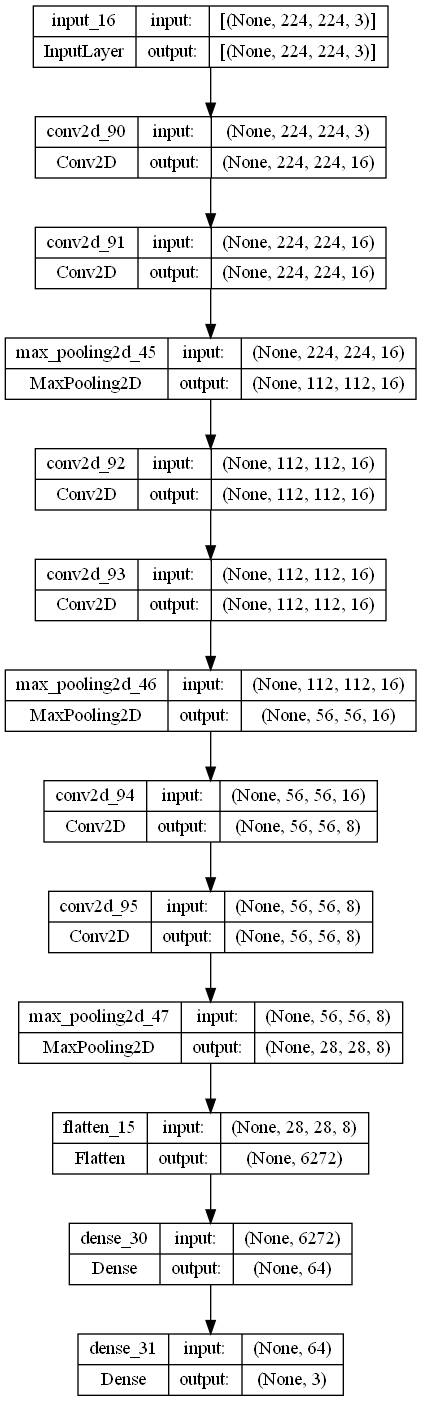

In [125]:
# model development

img_shape = x_train[0].shape
# nclass= np.shape(y_test)[-1]
nclass = len(np.unique(y_train))

# create the CNN with sequential api
model = Sequential()
model.add(InputLayer(input_shape=img_shape)) # input layers

#feature extraction
model.add(Conv2D(16,(3,3),padding='same',activation='relu',input_shape=img_shape))
model.add(Conv2D(16,(3,3),padding='same',activation='relu', input_shape=img_shape))
model.add(MaxPool2D())

model.add(Conv2D(16,(3,3),padding='same',activation='relu'))
model.add(Conv2D(16,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(8,(3,3),padding='same',activation='relu'))
model.add(Conv2D(8,(3,3),padding='same',activation='relu'))
model.add(MaxPool2D())

#classifier
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(nclass,activation='softmax')) #output layers
model.summary()

# model compile and plot the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
plot_model(model,show_shapes=True)


In [126]:
# include tensorboard and early stopping 
log_path = os.path.join(os.getcwd(),datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb = TensorBoard(log_dir=log_path)
es = EarlyStopping(monitor="loss", patience=10)

# model training
batch_size = 16
epoch = 20
hist = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=batch_size,epochs=epoch,callbacks=[tb,es])

Epoch 1/20
42/42 [==============================] - 35s 754ms/step - loss: 1.0975 - accuracy: 0.3531 - val_loss: 1.0982 - val_accuracy: 0.3191
Epoch 2/20
42/42 [==============================] - 30s 713ms/step - loss: 1.0974 - accuracy: 0.3516 - val_loss: 1.0945 - val_accuracy: 0.3191
Epoch 3/20
42/42 [==============================] - 29s 684ms/step - loss: 1.0782 - accuracy: 0.4064 - val_loss: 1.1142 - val_accuracy: 0.3191
Epoch 4/20
42/42 [==============================] - 32s 756ms/step - loss: 0.8131 - accuracy: 0.5753 - val_loss: 0.5002 - val_accuracy: 0.7589
Epoch 5/20
42/42 [==============================] - 29s 691ms/step - loss: 0.5378 - accuracy: 0.6895 - val_loss: 0.5142 - val_accuracy: 0.6667
Epoch 6/20
42/42 [==============================] - 28s 677ms/step - loss: 0.4913 - accuracy: 0.7047 - val_loss: 0.3986 - val_accuracy: 0.7766
Epoch 7/20
42/42 [==============================] - 29s 698ms/step - loss: 0.4370 - accuracy: 0.7854 - val_loss: 0.3140 - val_accuracy: 0.8865

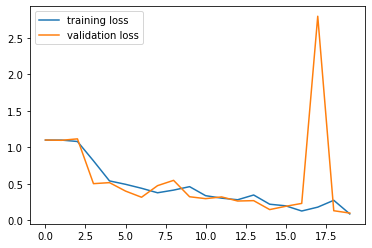

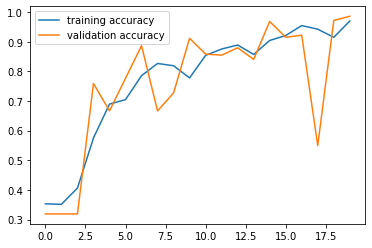

In [127]:
# model analysis
plt.figure()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['training loss', 'validation loss'])
plt.show()

plt.figure()
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['training accuracy', 'validation accuracy'])
plt.show()

9/9 [==============================] - 3s 259ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        88
           1       1.00      0.99      1.00       104
           2       0.97      1.00      0.98        90

    accuracy                           0.99       282
   macro avg       0.99      0.99      0.99       282
weighted avg       0.99      0.99      0.99       282



c:\Users\rahma\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


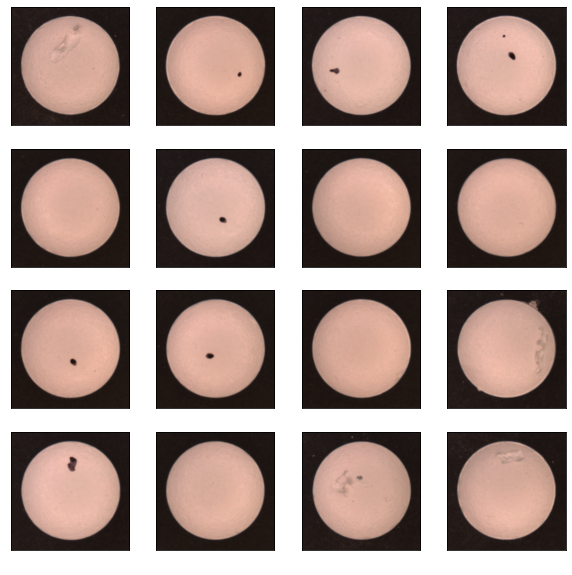

In [128]:
# model prediction
pred = model.predict(x_test)
y_pred = np.argmax(pred,axis=1)

# model test score
cm = confusion_matrix(y_test,y_pred)
cr = classification_report(y_test,y_pred)
print(cr)

# change back the label of target data as a list
pred_list = ohe.inverse_transform(y_pred.tolist())
test_list = ohe.inverse_transform(y_test.tolist())

# show result
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])
    plt.xlabel(f'L: {test_list[i]}, P: {pred_list[i]}').set_color('white') # L means Label and P means Prediction
plt.show()

In [129]:
# model deployment

# deployment path
model_path = os.path.join(os.getcwd(), 'model', 'model.h5')
label_path = os.path.join(os.getcwd(), 'model', 'label.pkl')

#save model
model.save(model_path)

# save label
with open(label_path,'wb') as f:
    pickle.dump(ohe,f)
